In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


### Listing files' path and extract their age and gender  

In [2]:
BASE_DIR = './UTKFace/'
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [3]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./UTKFace/100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,./UTKFace/100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,./UTKFace/100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,./UTKFace/100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,./UTKFace/100_1_0_20170112213303693.jpg.chip.jpg,100,1


### Plotting the age of pictures

<Axes: >

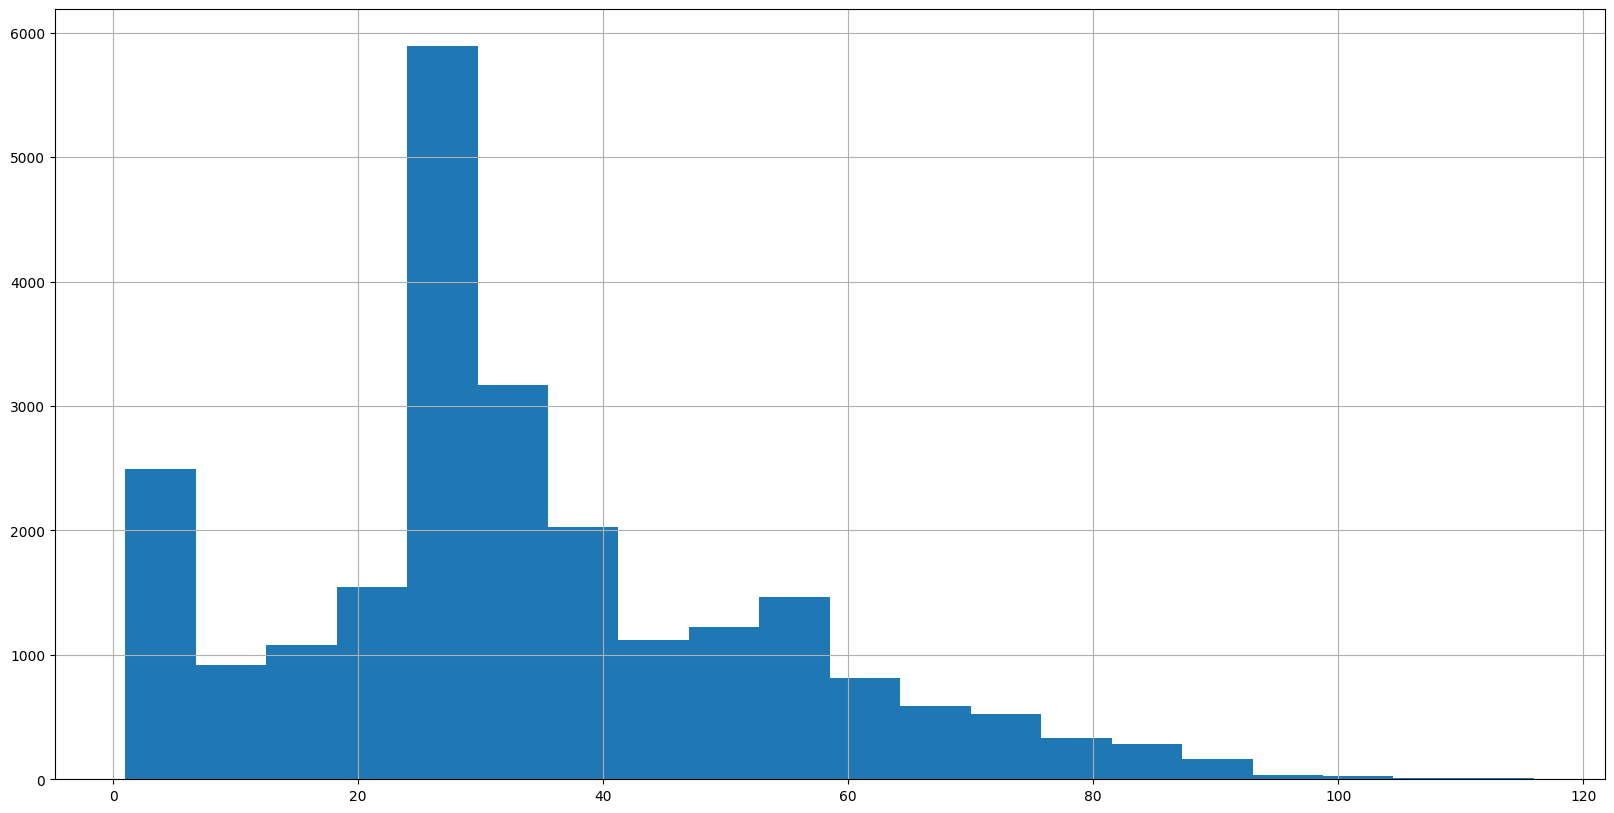

In [34]:
plt.figure(figsize=(20,10))
df['age'].hist(bins=20)

### Plotting the gender of pictures

<Axes: >

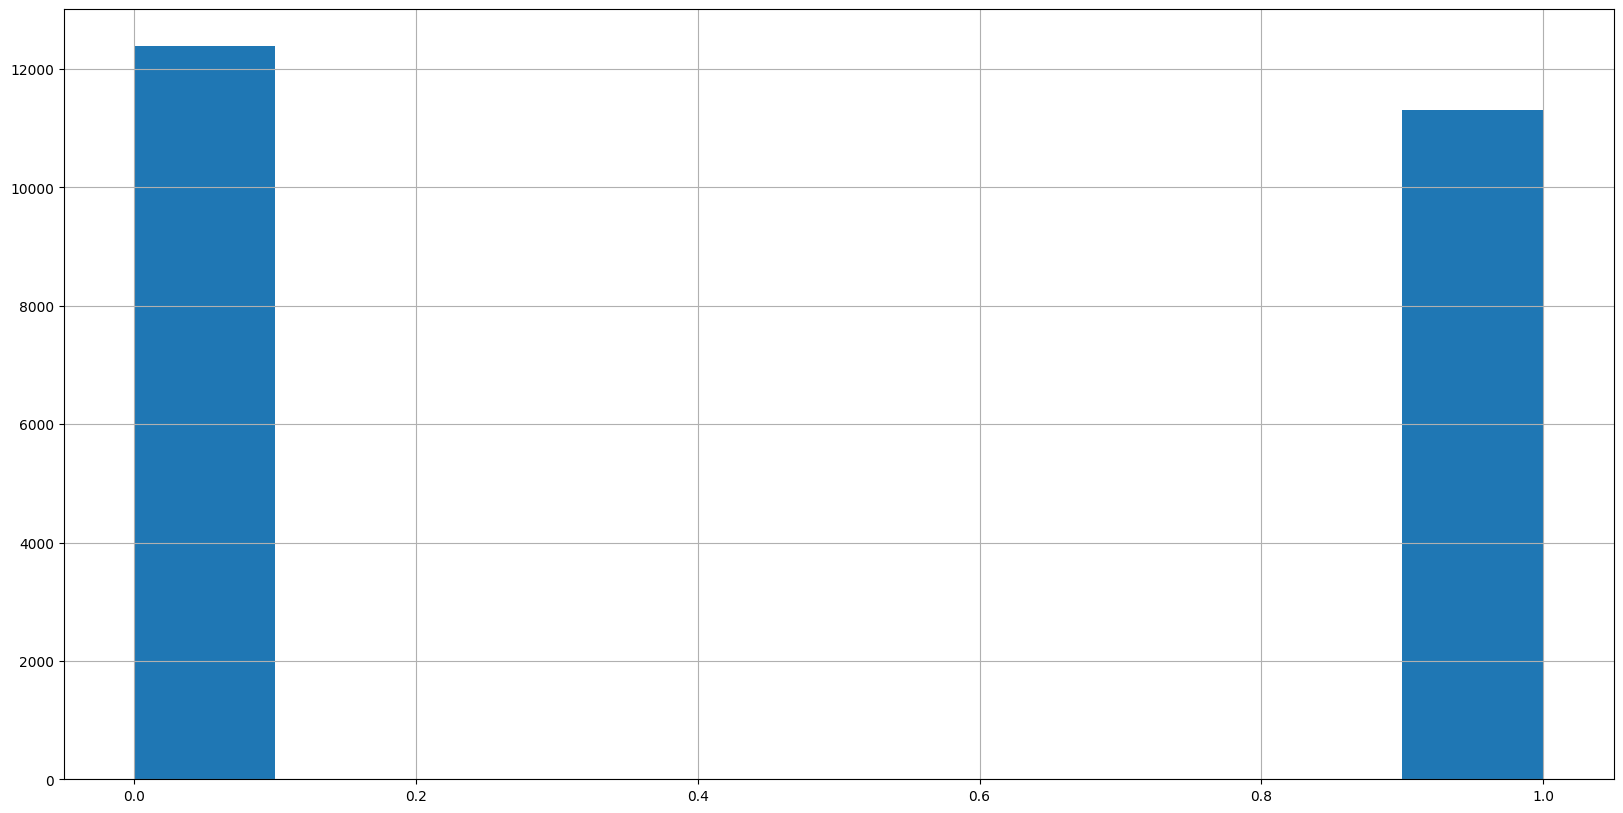

In [35]:
plt.figure(figsize=(20,10))
df['gender'].hist()

In [4]:
gender_dict = {0:'Male', 1:'Female'}

### some samples of the pictures

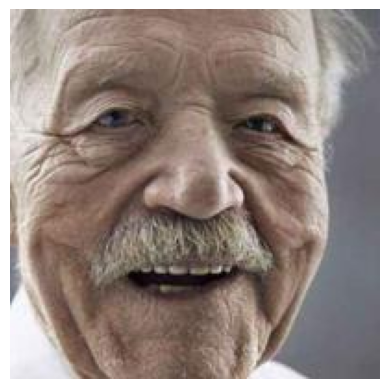

In [5]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

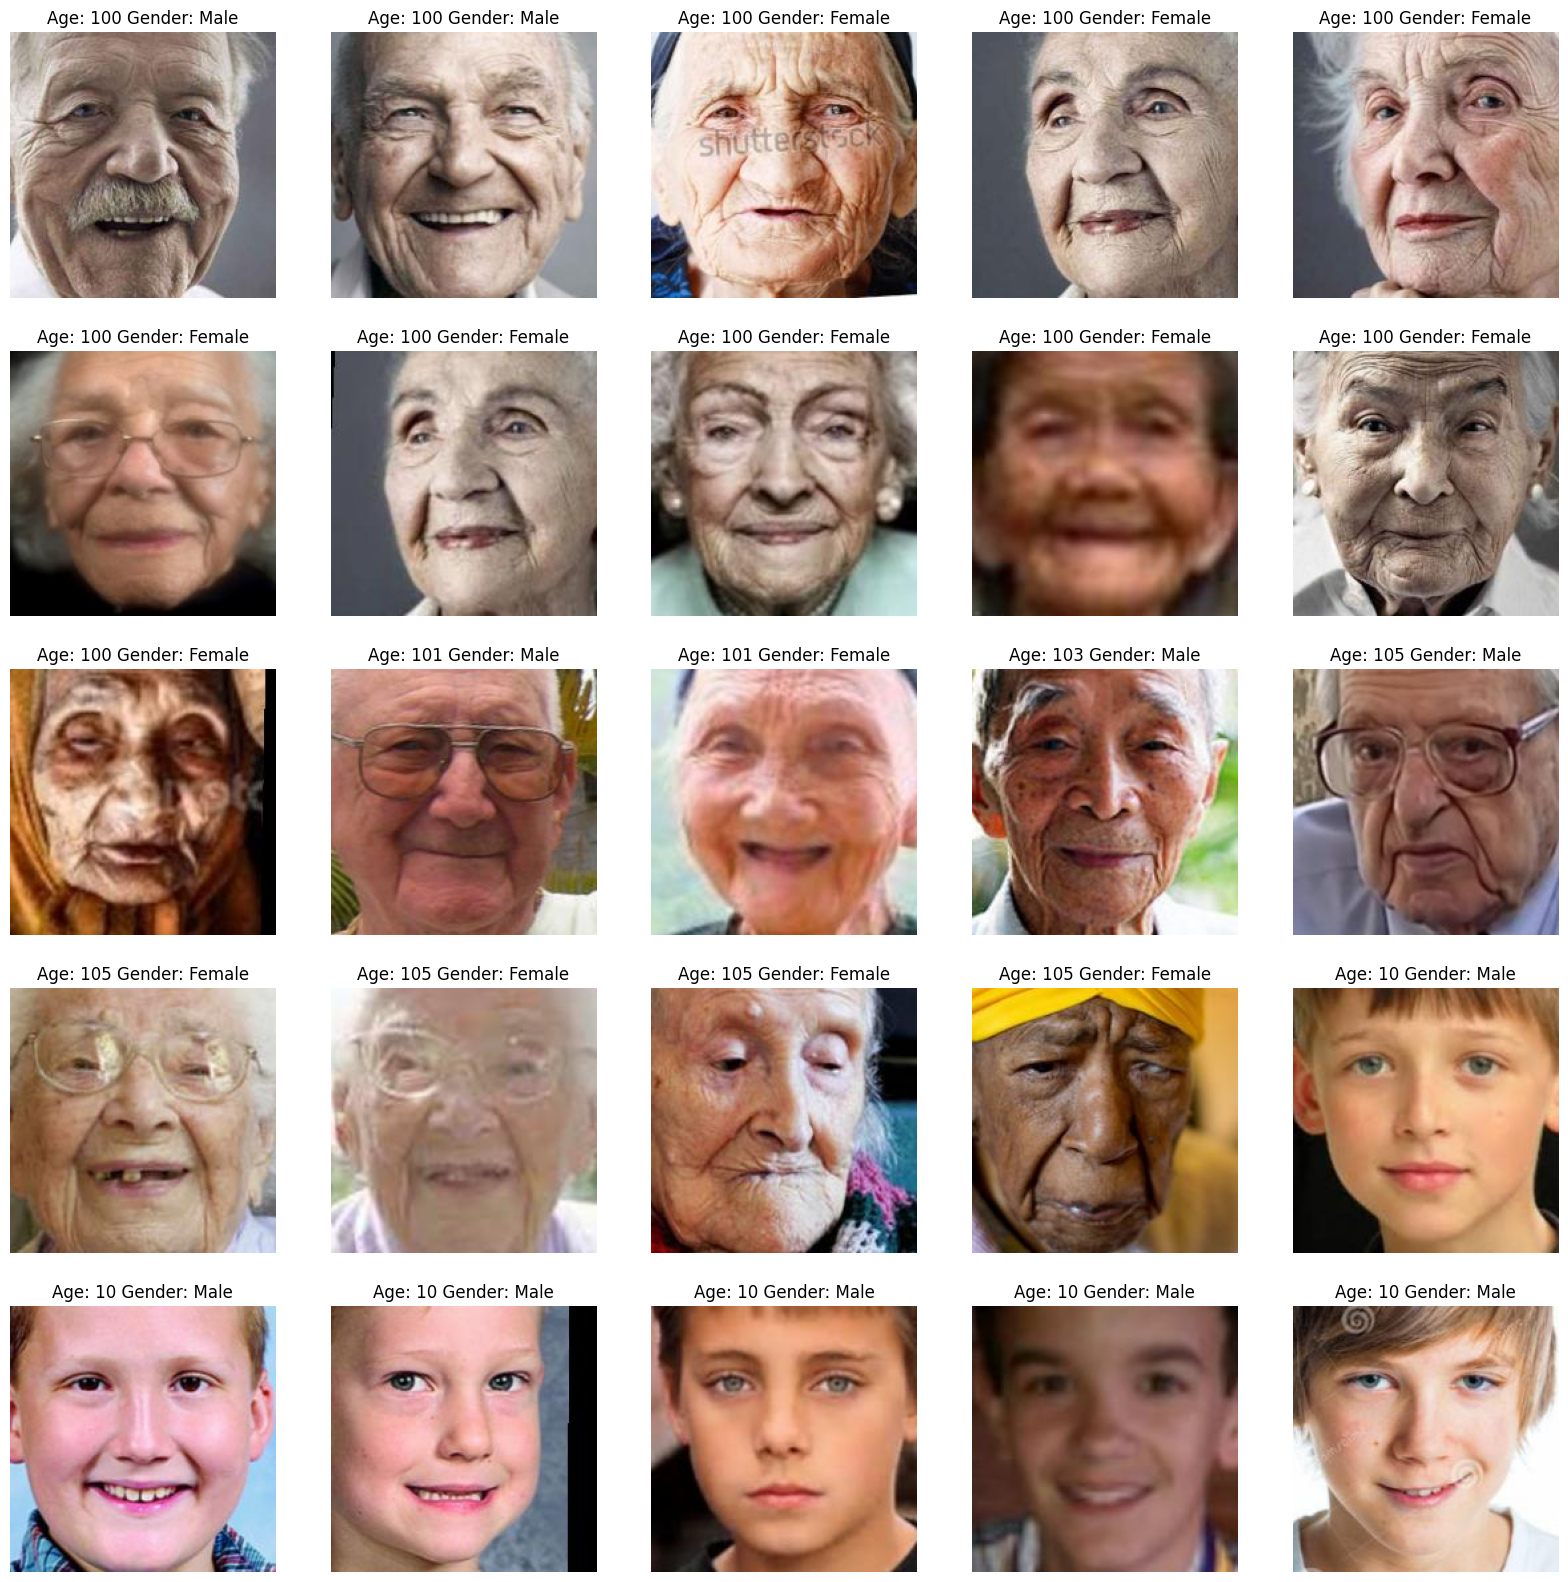

In [6]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

### Data Augmentation functions

In [16]:
def random_flip(image):
    return tf.image.random_flip_left_right(image)

def random_rotate(image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def random_color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

def convert_to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

def extract_features(images):
    features = []
    for image in images:
        img = load_img(image)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        img = img.reshape((128,128,3))
        img = random_flip(img)
        img = random_rotate(img)
        img = random_color_jitter(img)
        img = convert_to_grayscale(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
X = extract_features(df['image'])

In [18]:
X.shape

(23708, 128, 128, 1)

In [19]:
X = X/255.0

In [20]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [21]:
input_shape = (128, 128, 1)

### Model Definition

In [22]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [24]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 200s 338ms/step - age_out_mae: 5.2396 - gender_out_accuracy: 0.8761 - loss: 5.5172 - val_age_out_mae: 25.8484 - val_gender_out_accuracy: 0.7925 - val_loss: 26.3619
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 204s 343ms/step - age_out_mae: 5.0556 - gender_out_accuracy: 0.8886 - loss: 5.3031 - val_age_out_mae: 21.8442 - val_gender_out_accuracy: 0.7876 - val_loss: 22.3976
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 207s 349ms/step - age_out_mae: 4.8023 - gender_out_accuracy: 0.8879 - loss: 5.0490 - val_age_out_mae: 20.9532 - val_gender_out_accuracy: 0.7910 - val_loss: 21.5521
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 245s 320ms/step - age_out_mae: 4.7103 - gender_out_accuracy: 0.8958 - loss: 4.9428 - val_age_out_mae: 20.3369 - val_gender_out_accuracy: 0.7948 - val_loss: 20.9415
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 196s 331ms/step - age_out_mae: 4.6159 - gender_out_accuracy: 0.8953 - loss: 4.8449 - val_age_out_mae: 21.0461 - val_gender_out_accuracy: 0.7908 

### Gender Loss and accuracy

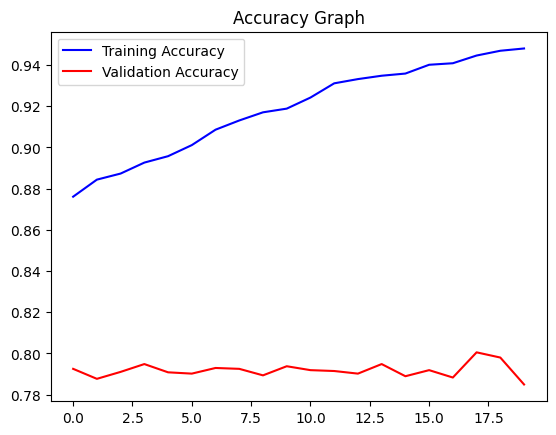

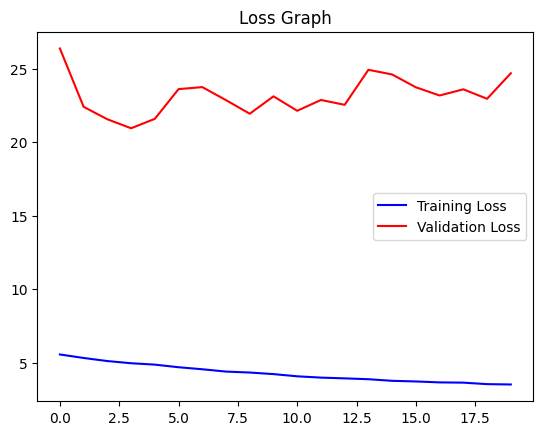

In [25]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


### Age Loss graph

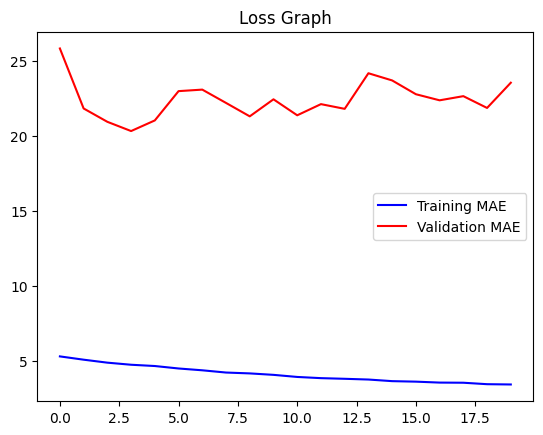

In [26]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Gender: Male Predicted Age: 8


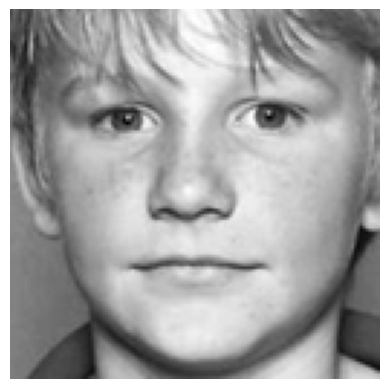

In [27]:
image_index = 44
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

### Saving Model

In [28]:
model.save('age_gender_detection.h5')